In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import random
from torch.autograd import Variable
import copy
from torch import nn, optim
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
import time
import math

In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
class Argments():
  def __init__(self):
    self.batch_size = 40
    self.test_batch = 1000
    self.global_epochs = 500
    self.local_epochs = 2
    self.lr = None
    self.momentum = 0.9
    self.weight_decay = 10**-4.0
    self.clip = 20.0
    self.partience = 500
    self.worker_num = 20
    self.sample_num = 20
    self.unlabeleddata_size = 1000
    self.device = torch.device('cuda:0'if torch.cuda.is_available() else'cpu')
    self.criterion = nn.CrossEntropyLoss()
    
    self.alpha_label = 0.5
    self.alpha_size = 10

args = Argments()

In [4]:
lr = 0

In [6]:
lr_list = []
lr_list.append(10**-3.0)
lr_list.append(10**-2.5)
lr_list.append(10**-2.0)
lr_list.append(10**-1.5)
lr_list.append(10**-1.0)
lr_list.append(10**-0.5)
lr_list.append(10**0.0)
lr_list.append(10**0.5)

args.lr = lr_list[lr]

In [9]:
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label
    
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class GlobalDataset(torch.utils.data.Dataset):
  def __init__(self,federated_dataset,transform=None):
    self.transform = transform
    self.data = []
    self.label = []
    for dataset in federated_dataset:
      for (data,label) in dataset:
        self.data.append(data)
        self.label.append(label)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = self.label[idx]
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

class UnlabeledDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None):
    self.transform = transform
    self.data = []
    self.target = None

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = 'unlabeled'
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

In [10]:
def get_dataset(Centralized=False,unlabeled_data=False):
    
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomCrop(32, padding=2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])
    transform_test = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])

    # download train data
    all_trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    # download test data
    all_testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

    
    ## get unlabeled dataset
    if unlabeled_data:
        unlabeled_dataset = UnlabeledDataset(transform_test)
        idx = sorted(random.sample(range(len(all_trainset)),args.unlabeleddata_size))
        unlabeled_dataset.data = np.array([all_trainset.data[i]  for i in idx])
        all_trainset.data = np.delete(all_trainset.data,idx,0)
        all_trainset.targets = np.delete(all_trainset.targets,idx,0)
    all_train_data = np.array(all_trainset.data)
    all_train_label = np.array(all_trainset.targets)
    all_test_data = np.array(all_testset.data)
    all_test_label = np.array(all_testset.targets)
    print('Train:{} Test:{}'.format(len(all_train_data),len(all_test_data)))


    ## Data size heterogeneity
    data_proportions = np.random.dirichlet(np.repeat(args.alpha_size, args.worker_num))
    train_data_proportions = np.array([0 for _ in range(args.worker_num)])
    test_data_proportions = np.array([0 for _ in range(args.worker_num)])
    for i in range(len(data_proportions)):
        if i==(len(data_proportions)-1):
            train_data_proportions = train_data_proportions.astype('int64')
            test_data_proportions = test_data_proportions.astype('int64')
            train_data_proportions[-1] = len(all_train_data) - np.sum(train_data_proportions[:-1])
            test_data_proportions[-1] = len(all_test_data) - np.sum(test_data_proportions[:-1])
        else:
            train_data_proportions[i] = (data_proportions[i] * len(all_train_data))
            test_data_proportions[i] = (data_proportions[i] * len(all_test_data))
    min_size = 0
    K = 10

    '''
    label_list = np.arange(10)
    np.random.shuffle(label_list)
    '''
    label_list = list(range(K))


    ## Data distribution heterogeneity
    while min_size<10:
        idx_train_batch = [[] for _ in range(args.worker_num)]
        idx_test_batch = [[] for _ in range(args.worker_num)]
        for k in label_list:
            proportions_train = np.random.dirichlet(np.repeat(args.alpha_label, args.worker_num))
            proportions_test = copy.deepcopy(proportions_train)
            idx_k_train = np.where(all_train_label == k)[0]
            idx_k_test = np.where(all_test_label == k)[0]
            np.random.shuffle(idx_k_train)
            np.random.shuffle(idx_k_test)
            ## Balance (train)
            proportions_train = np.array([p*(len(idx_j)<train_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_train,idx_train_batch))])
            proportions_train = proportions_train/proportions_train.sum()
            proportions_train = (np.cumsum(proportions_train)*len(idx_k_train)).astype(int)[:-1]
            idx_train_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_train_batch,np.split(idx_k_train,proportions_train))]

            ## Balance (test)
            proportions_test = np.array([p*(len(idx_j)<test_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_test,idx_test_batch))])
            proportions_test = proportions_test/proportions_test.sum()
            proportions_test = (np.cumsum(proportions_test)*len(idx_k_test)).astype(int)[:-1]
            idx_test_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_test_batch,np.split(idx_k_test,proportions_test))]

            min_size = min([len(idx_j) for idx_j in idx_train_batch])

    federated_trainset = []
    federated_testset = []
    for i in range(args.worker_num):
        ## create trainset
        data = [all_train_data[idx] for idx in idx_train_batch[i]]
        label = [all_train_label[idx] for idx in idx_train_batch[i]]
        federated_trainset.append(LocalDataset())
        federated_trainset[-1].data = data
        federated_trainset[-1].label = label

        ## create testset
        data = [all_test_data[idx] for idx in idx_test_batch[i]]
        label = [all_test_label[idx] for idx in idx_test_batch[i]]
        federated_testset.append(LocalDataset())
        federated_testset[-1].data = data
        federated_testset[-1].label = label

        
    ## split trainset
    federated_valset = [None]*args.worker_num
    for i in range(args.worker_num):
        n_samples = len(federated_trainset[i])
        if n_samples==1:
            train_subset = federated_trainset[i]
            val_subset = copy.deepcopy(federated_trainset[i])
        else:
            train_size = int(len(federated_trainset[i]) * 0.8) 
            val_size = n_samples - train_size 
            train_subset,val_subset = torch.utils.data.random_split(federated_trainset[i], [train_size, val_size])

        federated_trainset[i] = DatasetFromSubset(train_subset)
        federated_valset[i] = DatasetFromSubset(val_subset)

    ## show data distribution
    H = 4
    W = 5
    fig, axs = plt.subplots(H, W, figsize=(20, 5))
    x = np.arange(1,11)
    for i, (trainset,valset,testset) in enumerate(zip(federated_trainset,federated_valset,federated_testset)):
        bottom = [0]*10
        count = [0]*10
        for _,label in trainset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in valset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in testset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        #axs[int(i/W), i%W].title("worker{}".format(i+1), fontsize=12, color = "green")

    plt.show()

    ## get global dataset
    if Centralized:
        global_trainset = GlobalDataset(federated_trainset)
        global_valset = GlobalDataset(federated_valset)
        global_testset =  GlobalDataset(federated_testset)
        
        #show_cifer(global_trainset.data,global_testset.label, cifar10_labels)

        global_trainset.transform = transform_train
        global_valset.transform = transform_test
        global_testset.transform = transform_test

        global_trainloader = torch.utils.data.DataLoader(global_trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
        global_valloader = torch.utils.data.DataLoader(global_valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
        global_testloader = torch.utils.data.DataLoader(global_testset,batch_size=args.test_batch,shuffle=False,num_workers=2)

    ## set transform
    for i in range(args.worker_num):
        federated_trainset[i].transform = transform_train
        federated_valset[i].transform = transform_test
        federated_testset[i].transform = transform_test
    
    if Centralized and unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset
    if Centralized:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader
    elif unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,unlabeled_dataset
    else:
        return federated_trainset,federated_valset,federated_testset

Files already downloaded and verified
Files already downloaded and verified
Train:49000 Test:10000


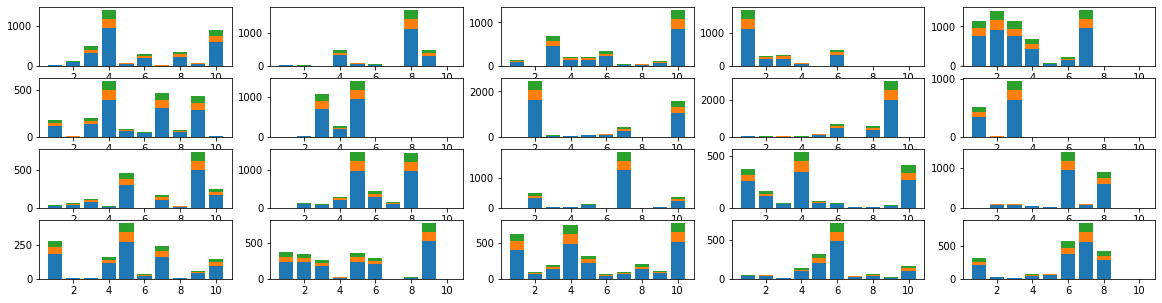

In [11]:
federated_trainset,federated_valset,federated_testset,unlabeled_dataset = get_dataset(unlabeled_data=True)

In [12]:
total = [0,0,0]
for i in range(args.worker_num):
    total[0]+=len(federated_trainset[i])
    total[1]+=len(federated_valset[i])
    total[2]+=len(federated_testset[i])
print(total)

[39191, 9809, 10000]


In [14]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            #print("in_channels: {}, v: {}".format(in_channels, v))
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


class VGGConvBlocks(nn.Module):
    '''
    VGG containers that only contains the conv layers 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class VGGContainer(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, input_dim, hidden_dims, num_classes=10):
        super(VGGContainer, self).__init__()
        self.features = features
        # note: we hard coded here a bit by assuming we only have two hidden layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Linear(hidden_dims[1], num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def matched_vgg11(matched_shapes):
    # [(67, 27), (67,), (132, 603), (132,), (260, 1188), (260,), (261, 2340), (261,), (516, 2349), (516,), (517, 4644), (517,), 
    # (516, 4653), (516,), (516, 4644), (516,), (516, 515), (515,), (515, 515), (515,), (515, 10), (10,)]
    processed_matched_shape = [matched_shapes[0][0], 
                                'M', 
                                matched_shapes[2][0], 
                                'M', 
                                matched_shapes[4][0], 
                                matched_shapes[6][0], 
                                'M', 
                                matched_shapes[8][0], 
                                matched_shapes[10][0], 
                                'M', 
                                matched_shapes[12][0], 
                                matched_shapes[14][0], 
                                'M']
    return VGGContainer(make_layers(processed_matched_shape), input_dim=matched_shapes[16][0], 
            hidden_dims=[matched_shapes[16][1], matched_shapes[18][1]], num_classes=10)


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes=10):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes=num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [15]:
class Server():
  def __init__(self):
    self.global_model = vgg13()
 

  def create_worker(self,federated_trainset,federated_valset,federated_testset):
    workers = []
    for i in range(args.worker_num):
      workers.append(Worker(federated_trainset[i],federated_valset[i],federated_testset[i]))
    return workers

  def sample_worker(self,workers):
    sample_worker = []
    sample_num = random.sample(range(args.worker_num),args.sample_num)
    for i in sample_num:
      sample_worker.append(workers[i])
    return sample_worker


  def send_model(self,workers):
    nums = 0
    for worker in workers:
      nums += worker.train_data_num

    for worker in workers:
      worker.aggregation_weight = 1.0*worker.train_data_num/nums
      worker.global_model = copy.deepcopy(self.global_model)


  def aggregate_model(self,workers):   
    new_params = OrderedDict()
    for i,worker in enumerate(workers):
      worker_state = worker.global_model.state_dict()
      for key in worker_state.keys():
        if i==0:
          new_params[key] = worker_state[key]*worker.aggregation_weight
        else:
          new_params[key] += worker_state[key]*worker.aggregation_weight
      del worker.global_model 
    self.global_model.load_state_dict(new_params)

In [16]:
class Worker():
  def __init__(self,trainset,valset,testset):
    self.train_data_num = len(trainset)
    self.test_data_num = len(testset)
    if len(trainset)<=2 :
      trainset = [trainset,copy.deepcopy(trainset),copy.deepcopy(trainset)]
    else:
      split_len = [(len(trainset) + i) // 3 for i in range(3)]
      trainset = torch.utils.data.random_split(trainset,split_len)
    self.trainloader_local = torch.utils.data.DataLoader(trainset[0],batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.trainloader_lambda = torch.utils.data.DataLoader(trainset[1],batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.trainloader_global = torch.utils.data.DataLoader(trainset[2],batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.valloader = torch.utils.data.DataLoader(valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.testloader = torch.utils.data.DataLoader(testset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.global_model = None
    self.local_model = vgg13()
    self.mix_model = None
    self.lmd = None
    self.aggregation_weight = None


  def local_train(self):
    loss = float('inf')
    self.mix_model = vgg13()
    model_tmp = vgg13()
    for lmd in np.arange(0.0,1.1,0.1):
      new_params = OrderedDict()
      global_state = self.global_model.state_dict()
      local_state = self.local_model.state_dict()
      for key in global_state.keys():
        new_params[key] = lmd*local_state[key] + (1.0-lmd)*global_state[key]     
      model_tmp.load_state_dict(new_params)
      model_tmp = model_tmp.to(args.device)
      if lmd!=0.0:
        _,_ = train(model_tmp,args.criterion,self.trainloader_local,args.local_epochs)

      _,tmp = test(model_tmp,args.criterion,self.trainloader_lambda)
      if tmp<loss:
        loss = tmp
        self.lmd = lmd
        self.mix_model = copy.deepcopy(model_tmp)

    if self.lmd!=0.0:
      self.mix_model = self.mix_model.to('cpu')
      new_params = OrderedDict()
      mix_state = self.mix_model.state_dict()
      global_state = self.global_model.state_dict()
      for key in global_state.keys():
        new_params[key] = (mix_state[key] - (1.0-self.lmd)*global_state[key])/self.lmd    
      self.local_model.load_state_dict(new_params)
      self.mix_model = self.mix_model.to(args.device)
    
    model_tmp = model_tmp.to('cpu')
    del model_tmp


  def global_train(self):
    model_tmp = copy.deepcopy(self.mix_model)
    model_tmp = model_tmp.to('cpu')
    acc_train,loss_train = train(self.mix_model,args.criterion,self.trainloader_global,args.local_epochs)
    acc_valid,loss_valid = test(self.mix_model,args.criterion,self.valloader)
    self.mix_model = self.mix_model.to('cpu')
    new_params = OrderedDict()
    new_state = self.mix_model.state_dict()
    old_state = model_tmp.state_dict()
    global_state = self.global_model.state_dict()
    for key in new_state.keys():
        new_params[key] = global_state[key]+new_state[key]-old_state[key]  
    self.global_model.load_state_dict(new_params)
    del self.mix_model
    del model_tmp
    return acc_train,loss_train,acc_valid,loss_valid


  def test_step(self):
    self.local_train()
    mix_model = vgg13()
    new_params = OrderedDict()
    global_state = self.global_model.state_dict()
    local_state = self.local_model.state_dict()
    for key in global_state.keys():
      new_params[key] = self.lmd*local_state[key] + (1.0-self.lmd)*global_state[key]     
    mix_model.load_state_dict(new_params)
    mix_model = mix_model.to(args.device)
    acc,loss = test(mix_model,args.criterion,self.testloader)
    return acc,loss

In [17]:
def train(model,criterion,trainloader,epochs):
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    for (data,labels) in trainloader:
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      count += len(labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()

  return 100.0*correct/count,running_loss/len(trainloader)



In [18]:
def test(model,criterion,testloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  count = 0
  for (data,labels) in testloader:
    data,labels = data.to(args.device),labels.to(args.device)
    outputs = model(data)
    running_loss += criterion(outputs,labels).item()
    predicted = torch.argmax(outputs,dim=1)
    correct += (predicted==labels).sum().item()
    count += len(labels)

  accuracy = 100.0*correct/count
  loss = running_loss/len(testloader)


  return accuracy,loss

In [19]:
class Early_Stopping():
  def __init__(self,partience):
    self.step = 0
    self.loss = float('inf')
    self.partience = partience

  def validate(self,loss):
    if self.loss<loss:
      self.step += 1
      if self.step>self.partience:
        return True
    else:
      self.step = 0
      self.loss = loss

    return False

In [20]:
server = Server()
workers = server.create_worker(federated_trainset,federated_valset,federated_testset)
acc_train = []
loss_train = []
acc_valid = []
loss_valid = []

early_stopping = Early_Stopping(args.partience)

start = time.time()

for epoch in range(args.global_epochs):
  sample_worker = server.sample_worker(workers)
  server.send_model(sample_worker)

  acc_train_avg = 0.0
  loss_train_avg = 0.0
  acc_valid_avg = 0.0
  loss_valid_avg = 0.0
  for worker in sample_worker:
    worker.local_train()
    acc_train_tmp,loss_train_tmp,acc_valid_tmp,loss_valid_tmp = worker.global_train()
    acc_train_avg += acc_train_tmp/len(sample_worker)
    loss_train_avg += loss_train_tmp/len(sample_worker)
    acc_valid_avg += acc_valid_tmp/len(sample_worker)
    loss_valid_avg += loss_valid_tmp/len(sample_worker)
  server.aggregate_model(sample_worker)
  '''
  server.model.to(args.device)
  for worker in workers:
    acc_valid_tmp,loss_valid_tmp = test(server.model,args.criterion,worker.valloader)
    acc_valid_avg += acc_valid_tmp/len(workers)
    loss_valid_avg += loss_valid_tmp/len(workers)
  server.model.to('cpu')
  '''
  print('Epoch{}  loss:{}  accuracy:{}'.format(epoch+1,loss_valid_avg,acc_valid_avg))
  acc_train.append(acc_train_avg)
  loss_train.append(loss_train_avg)
  acc_valid.append(acc_valid_avg)
  loss_valid.append(loss_valid_avg)

  if early_stopping.validate(loss_valid_avg):
    print('Early Stop')
    break
    
end = time.time()

Epoch1  loss:1.9024672597646715  accuracy:43.361738372675624
Epoch2  loss:1.725651529431343  accuracy:43.01639389814469
Epoch3  loss:1.64758386015892  accuracy:43.253198286586645
Epoch4  loss:1.5574744969606398  accuracy:43.294766489151115
Epoch5  loss:1.507778772711754  accuracy:43.65411625525491
Epoch6  loss:1.492500802874565  accuracy:42.773352788698254
Epoch7  loss:1.4849084585905077  accuracy:43.46917181408191
Epoch8  loss:1.4792048543691636  accuracy:42.90114351557359
Epoch9  loss:1.4662846982479096  accuracy:43.31910945632757
Epoch10  loss:1.4622665405273438  accuracy:43.352575875033295
Epoch11  loss:1.4498973667621613  accuracy:43.403309668035526
Epoch12  loss:1.4478833287954331  accuracy:45.220156327990296
Epoch13  loss:1.4387569487094878  accuracy:44.42080670861843
Epoch14  loss:1.4409559071063995  accuracy:43.55640289898183
Epoch15  loss:1.4299666523933412  accuracy:45.07803777535489
Epoch16  loss:1.4285402745008469  accuracy:45.449982359277385
Epoch17  loss:1.42050164937973

Epoch136  loss:1.0886275619268415  accuracy:61.28404070569141
Epoch137  loss:1.0785778790712357  accuracy:61.681431350288044
Epoch138  loss:1.0711193919181825  accuracy:61.67065072086708
Epoch139  loss:1.0876996099948881  accuracy:61.226326696494425
Epoch140  loss:1.0849184438586235  accuracy:61.24107883707998
Epoch141  loss:1.0773501247167585  accuracy:61.341004609491314
Epoch142  loss:1.0674826726317408  accuracy:61.255879250142584
Epoch143  loss:1.0855776846408844  accuracy:60.814320510786025
Epoch144  loss:1.0826880410313606  accuracy:61.94873667970858
Epoch145  loss:1.079545506834984  accuracy:61.63133109330131
Epoch146  loss:1.0713707819581033  accuracy:62.020174047533246
Epoch147  loss:1.0798388808965682  accuracy:61.72652297003235
Epoch148  loss:1.0772430270910263  accuracy:61.4970610454445
Epoch149  loss:1.0677188381552696  accuracy:62.227432589953054
Epoch150  loss:1.0659338235855103  accuracy:61.787434478840005
Epoch151  loss:1.0816661432385442  accuracy:61.59850257028169
Ep

Epoch269  loss:1.067303716391325  accuracy:63.729333645210794
Epoch270  loss:1.0717441733926536  accuracy:63.253417907755384
Epoch271  loss:1.067143155634403  accuracy:62.57069975733381
Epoch272  loss:1.0565537681803108  accuracy:64.28854412999084
Epoch273  loss:1.0616679593920706  accuracy:63.954458279318054
Epoch274  loss:1.0646733846515417  accuracy:63.26604264785533
Epoch275  loss:1.0328348599374295  accuracy:64.37088687540385
Epoch276  loss:1.0548446252942085  accuracy:64.36572147221985
Epoch277  loss:1.050640894472599  accuracy:63.97801032228219
Epoch278  loss:1.0607966117560863  accuracy:63.35707554600577
Epoch279  loss:1.0574636764824388  accuracy:63.36134542508207
Epoch280  loss:1.025670679286122  accuracy:64.81149084710745
Epoch281  loss:1.0478616178035733  accuracy:63.182153304306205
Epoch282  loss:1.0681006312370298  accuracy:63.70485583963409
Epoch283  loss:1.0458003960549829  accuracy:64.18373370532818
Epoch284  loss:1.0308327566832303  accuracy:64.30821781915354
Epoch285

Epoch402  loss:1.0876073494553566  accuracy:63.345044674812726
Epoch403  loss:1.059164663590491  accuracy:64.7258179505298
Epoch404  loss:1.1739774793386462  accuracy:60.83104765252247
Epoch405  loss:1.1159338703379036  accuracy:62.765515002291195
Epoch406  loss:1.1129788979887962  accuracy:63.704972537583615
Epoch407  loss:1.1013968452811242  accuracy:63.01746197885051
Epoch408  loss:1.1721352599561212  accuracy:61.09461172582728
Epoch409  loss:1.079307480342686  accuracy:64.44412943686962
Epoch410  loss:1.0898219354450702  accuracy:64.0555196025366
Epoch411  loss:1.066540462523699  accuracy:63.853924197452855
Epoch412  loss:1.101203860342503  accuracy:63.43537351049741
Epoch413  loss:1.132410748489201  accuracy:61.769249007176235
Epoch414  loss:1.1272393494844437  accuracy:61.94696192026489
Epoch415  loss:1.0613232623320072  accuracy:63.517619966174934
Epoch416  loss:1.1687615543603898  accuracy:60.77310815741037
Epoch417  loss:1.0981245163828135  accuracy:63.17946527890714
Epoch418 

In [22]:
acc_test = []
loss_test = []

nums = 0
for worker in workers:
  nums += worker.test_data_num

start = time.time()

for i,worker in enumerate(workers):
  worker.aggregation_weight = 1.0*worker.test_data_num/nums
  worker.global_model = copy.deepcopy(server.global_model)
  worker.local_train()
  acc_tmp,loss_tmp = test(worker.mix_model,args.criterion,worker.testloader)
  acc_test.append(acc_tmp)
  loss_test.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
  worker.mix_model = worker.mix_model.to('cpu')
  del worker.mix_model,worker.global_model

end = time.time()

acc_test_avg = sum(acc_test)/len(acc_test)
loss_test_avg = sum(loss_test)/len(loss_test)
print('Test  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 accuracy:36.712749615975426  loss:1.7518707513809204
Worker2 accuracy:70.28688524590164  loss:1.11521577835083
Worker3 accuracy:62.285714285714285  loss:1.193273901939392
Worker4 accuracy:75.7936507936508  loss:1.715030312538147
Worker5 accuracy:72.78048780487805  loss:0.9932506382465363
Worker6 accuracy:50.97493036211699  loss:2.169666051864624
Worker7 accuracy:50.10526315789474  loss:0.9831329584121704
Worker8 accuracy:77.46650426309378  loss:1.119786024093628
Worker9 accuracy:81.65605095541402  loss:0.9980876445770264
Worker10 accuracy:79.76190476190476  loss:0.4624582529067993
Worker11 accuracy:65.71428571428571  loss:1.5716962814331055
Worker12 accuracy:49.49640287769784  loss:1.4958406686782837
Worker13 accuracy:76.93877551020408  loss:0.7057133913040161
Worker14 accuracy:58.96551724137931  loss:1.7432740926742554
Worker15 accuracy:51.851851851851855  loss:1.675270915031433
Worker16 accuracy:41.048034934497814  loss:1.6348832845687866
Worker17 accuracy:51.41509433962264  